In [1]:
import numpy as np
import pandas as pd
import os
import statistics

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

import preprocessing

pd.set_option('display.max_columns', 500)
warnings.filterwarnings(action = 'ignore')

In [2]:
train_original = pd.read_csv('data/train.csv')
test_original = pd.read_csv('data/test.csv')

train = train_original.copy()
test = test_original.copy()

In [3]:
train = preprocessing.make_sum_column(train)
test = preprocessing.make_sum_column(test)

train = preprocessing.time_data(train)
test = preprocessing.time_data(test)

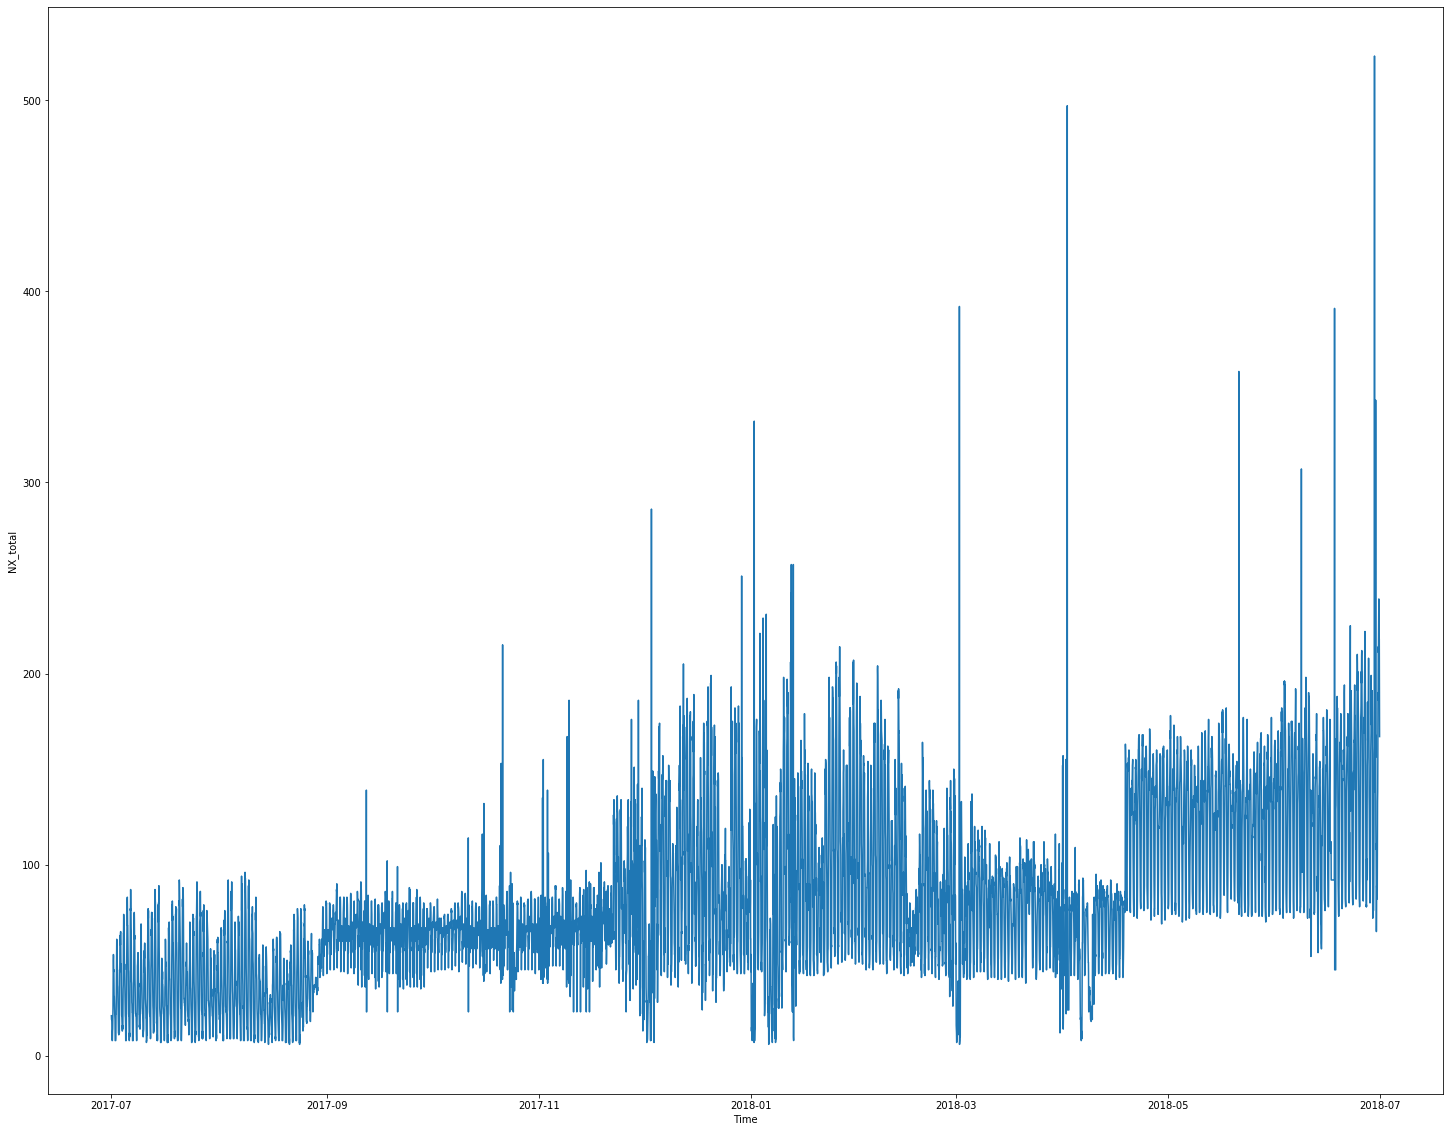

In [4]:
fig, ax = plt.subplots(1, 1, figsize = (25, 20))

sns.lineplot(x = 'Time', y = 'NX_total', ax = ax, data = test)
plt.show()

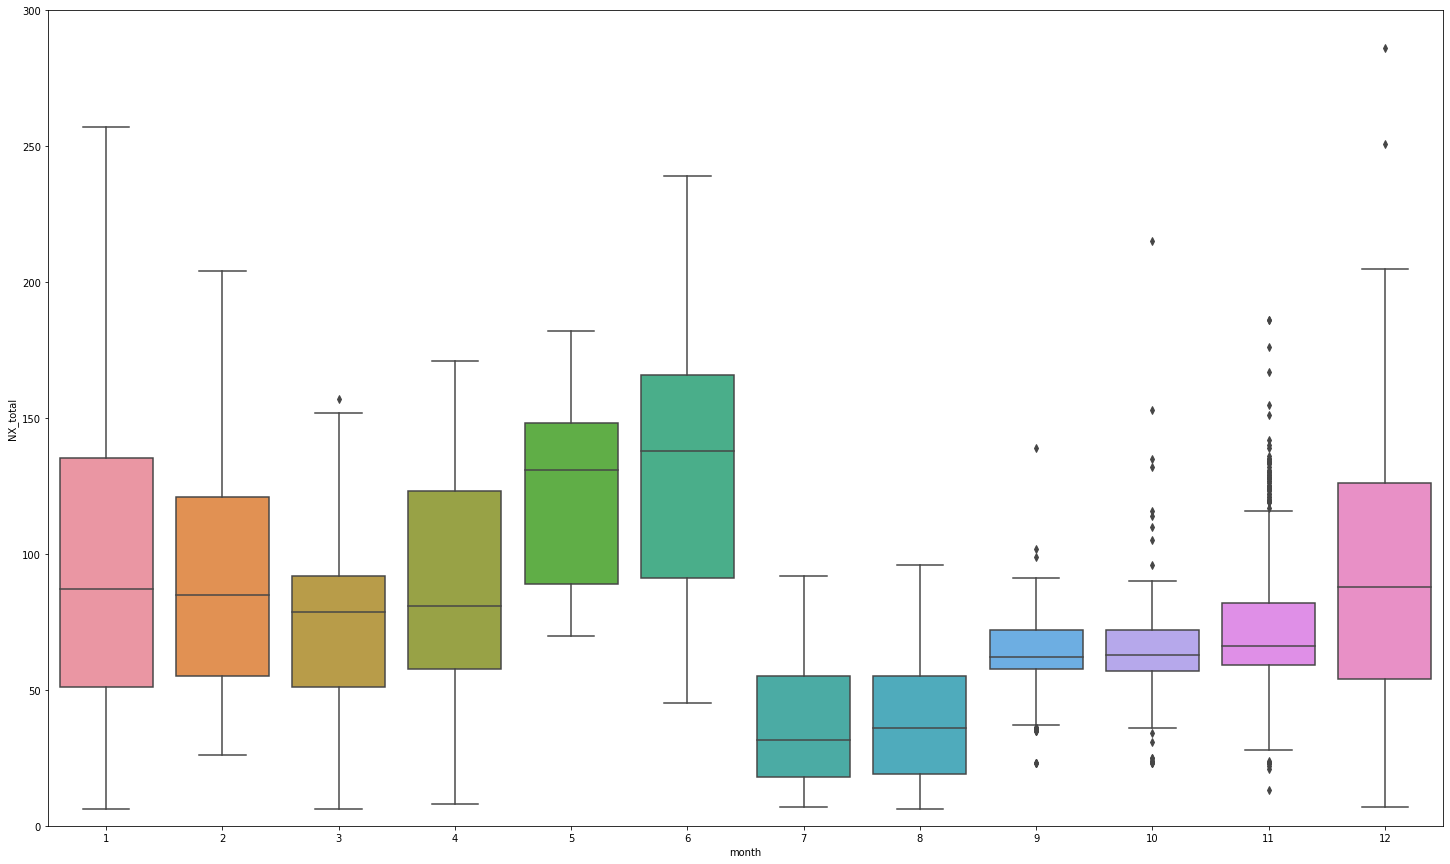

In [5]:
fig, ax = plt.subplots(1, 1, figsize = (25, 15))

sns.boxplot(x = 'month', y = 'NX', ax = ax, data = test)
plt.ylim((0, 300))
plt.show()

In [6]:
null_count = [0] * (train_original.shape[1] -1)
for length in range(train_original.shape[1] - 1) :
    null_count[length] = sum(train_original.iloc[ : , length + 1].isnull())

In [7]:
column = train_original.columns[1 : ]
null_counts = pd.DataFrame({'columns' :column, 
                           'null_count' : null_count})
null_counts.describe()

,null_count
count,1300.000000
mean,13054.977692
std,2421.513256
min,0.000000
25%,13842.000000
50%,13846.500000
75%,13873.250000
max,16909.000000


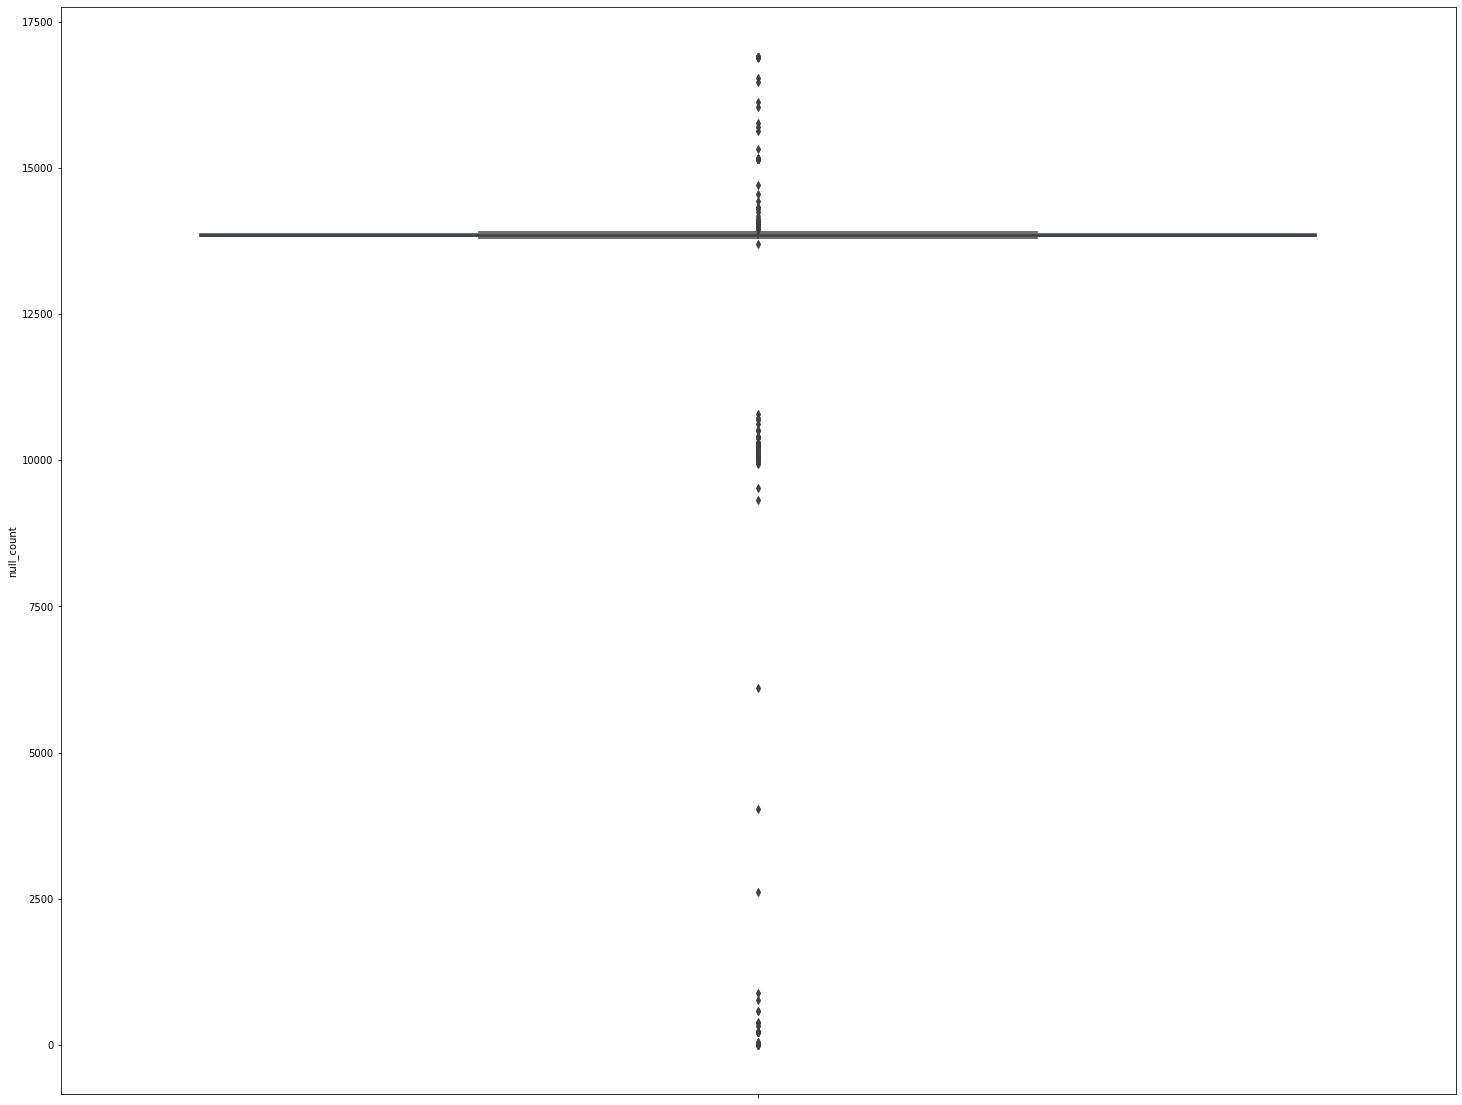

In [9]:
fig, ax = plt.subplots(1, 1, figsize = (25, 20))

sns.boxplot(y = 'null_count', ax = ax, data = null_counts)
plt.show()

In [23]:
print('The number of house that has under 7500 null is {0}'.format(len(null_counts[null_counts['null_count'] < 7500])))
print('The number of house that has under 10000 null is {0}'.format(len(null_counts[null_counts['null_count'] < 10000])))
print('The number of house that has under 12500 null is {0}'.format(len(null_counts[null_counts['null_count'] < 12500])))

The number of house that has under 7500 null is 31
The number of house that has under 10000 null is 36
The number of house that has under 12500 null is 234


In [48]:
valuable_house = null_counts[null_counts['null_count'] < 12500]['columns']
valuable_train = train[valuable_house]

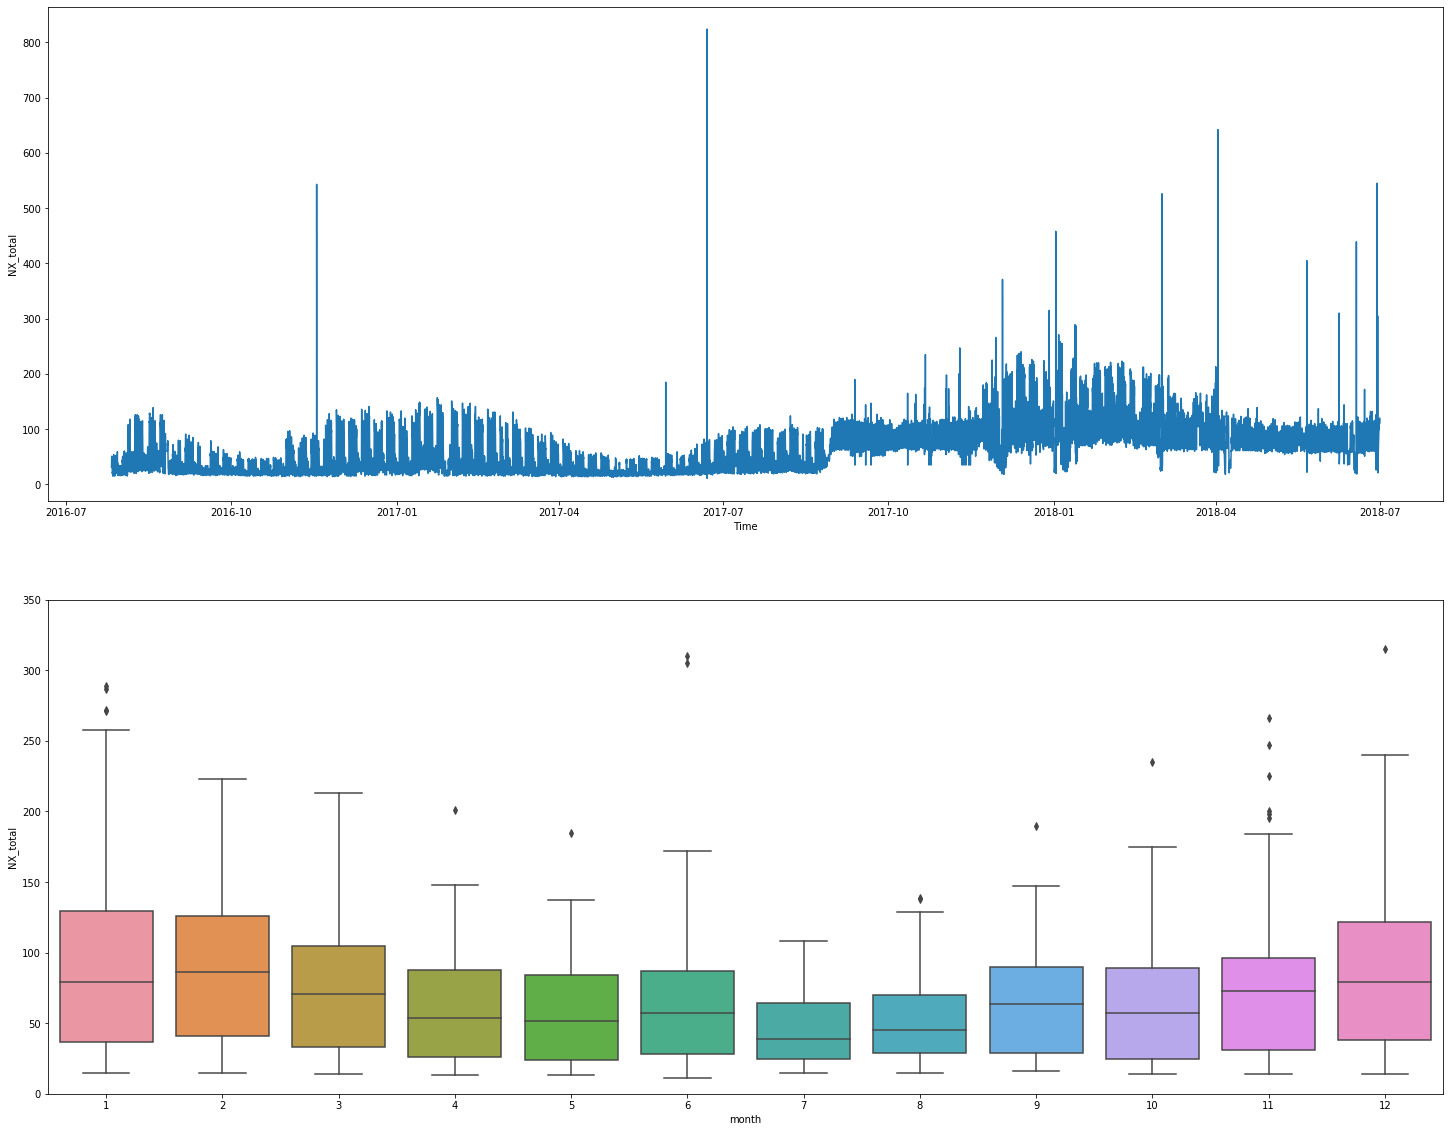

In [50]:
valuable_train = preprocessing.make_sum_column(valuable_train)
fig, ax = plt.subplots(2, 1, figsize = (25, 20))

sns.lineplot(x = train.Time, y = valuable_train.NX_total, ax = ax[0])

sns.boxplot(x = train.month, y = valuable_train.NX_total, ax = ax[1])
plt.ylim(0, 350)
plt.show()